In [24]:
import os
import numpy as np
import art
import torchvision
from torchvision import transforms as transforms
from PIL import Image
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

Loading models, both of them are pretrained on COCO dataset <br />
Here is link to model documentation: https://pytorch.org/vision/stable/models.html#faster-r-cnn

In [25]:
#we can train torch model and pass is to art_estimator
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
art_model = art.estimators.object_detection.PyTorchFasterRCNN(model = model, clip_values=[0,255])

In [26]:
art_model = art.estimators.object_detection.PyTorchFasterRCNN(clip_values=[0,255])

Check basic usage of network, we give a random image and check what it returns.
It sometimes will detect something in this random image and we can look at the output.
Also we will use GPU if possible

In [27]:
inputs = torch.randn([3, 3456, 4608])
# checking for cuda 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = inputs.to(device)
out = model([inputs])
print(out)

[{'boxes': tensor([[   0.0000,  636.8267, 4607.9995, 3365.3894]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([3], device='cuda:0'), 'scores': tensor([0.0508], device='cuda:0', grad_fn=<IndexBackward>)}]


Let's read a real image and get them to our model

In [28]:
image = Image.open("giraffe.jpg").convert('RGB')

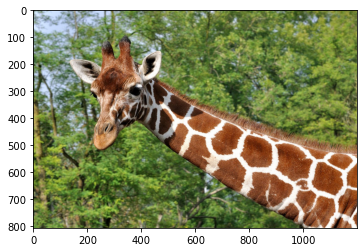

In [29]:
imgplot = plt.imshow(image)
plt.show()

In [30]:
giraffe_tensor = transforms.ToTensor()(image)
print(giraffe_tensor.shape)
giraffe_tensor = giraffe_tensor.to(device)

torch.Size([3, 806, 1200])


In [31]:
out = model([giraffe_tensor])
print(out)
label = out[0]['labels'].item()
print(label)

[{'boxes': tensor([[ 152.9368,   89.7184, 1188.7885,  796.6898]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([25], device='cuda:0'), 'scores': tensor([0.9991], device='cuda:0', grad_fn=<IndexBackward>)}]
25


Ok, our network detects something in the picture let's check if label: 25 is for giraffes

In [32]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [33]:
print(COCO_INSTANCE_CATEGORY_NAMES[label])

giraffe


We can put an np.array image directly to our model and get appropriate output

In [34]:
def make_predictions(img_path, art_model):
    """Returns predictions for image in img_path"""
    image = Image.open(img_path).convert('RGB')
    img_arr = np.array(image)
    img_arr = np.expand_dims(img_arr, 0)
    return art_model.predict(np.float32(img_arr)) #predictions 

In [35]:
predictions = make_predictions("giraffe2.jpg", art_model)
print(predictions)

[{'boxes': array([[ 693.65924,  174.52498, 1477.9994 , 1055.1589 ],
       [ 510.11496,  224.5522 , 1065.5365 , 1061.4241 ],
       [ 682.52734,  412.9922 , 1116.4353 , 1037.0057 ]], dtype=float32), 'labels': array([25, 25, 25], dtype=int64), 'scores': array([0.99933916, 0.997769  , 0.13987716], dtype=float32)}]


Now we can add predicted boxes to our picture <br/>
Pictures seems to be slightly too big

In [36]:
def draw_image_with_boxes(img_path):
    predictions = make_predictions(img_path,art_model )
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(predictions[0]['labels'])]
    boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(predictions[0]['boxes'])] # Bounding boxes
    pred_score = list(predictions[0]['scores'])
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    for i in range(len(boxes)):
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color= (255,0,0), thickness=2) # Draw rectangle
        cv2.putText(img,pred_class[i] + ", "+ str(round(pred_score[i],2)), boxes[i][0],  cv2.FONT_HERSHEY_PLAIN, 2, (255,0,0),thickness=2) # Write the prediction class and score     
    #plt.figure(figsize=(20,30)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

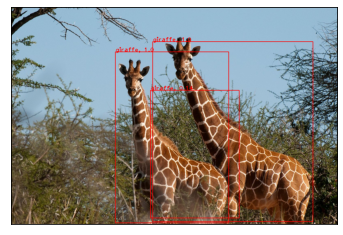

In [37]:
draw_image_with_boxes("giraffe2.jpg")

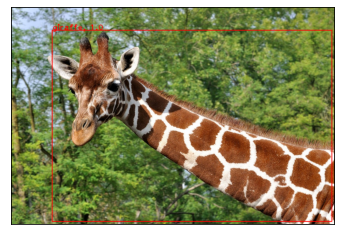

In [38]:
draw_image_with_boxes("giraffe.jpg")

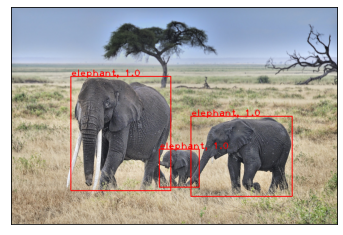

In [39]:
draw_image_with_boxes("elephant.jpg")

In [40]:
attackDPatch = art.attacks.evasion.DPatch(art_model)
attackRobustDPatch = art.attacks.evasion.RobustDPatch(art_model)

In [41]:
def make_images_array(dictionary, width,height):
    images_paths = [f for f in os.listdir(dictionary) if os.path.isfile(os.path.join(dictionary, f))]
    #(n,width,height,3)
    images_array = np.empty([len(images_paths),width,height,3])
    
    for i, image_path in enumerate(images_paths):
        image = Image.open(dictionary +"/" + image_path).convert('RGB')
        image = image.resize((width,height))
        img_arr = np.array(image)
        images_array[i,:,:,:] = np.array(image)
    return images_array

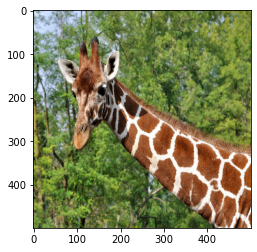

In [42]:
images_array = make_images_array("photos", 500, 500)
images_array = np.uint8(images_array)
image = Image.fromarray(images_array[1,:,:,:])
plt.imshow(image)
plt.show()

In [43]:
print(attackDPatch)
print(attackRobustDPatch)

Now we can conduct attact

In [44]:
image = Image.open("elephant.jpg").convert('RGB')
img_arr = np.array(image)
img_arr = np.expand_dims(img_arr, 0)
print(img_arr.shape)
adv_patch = attackRobustDPatch.generate(np.float32(img_arr))


(1, 683, 1024, 3)


RobustDPatch iteration:   0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
print(images_array.shape)

y_hat = art_model.predict(np.float32(img_arr))
print(y_hat)

(2, 500, 500, 3)
[{'boxes': array([[563.2966 , 345.4033 , 880.6374 , 596.13367],
       [187.74016, 220.00261, 500.19757, 578.8625 ],
       [464.5193 , 448.03387, 589.05597, 567.2614 ]], dtype=float32), 'labels': array([22, 22, 22], dtype=int64), 'scores': array([0.999671  , 0.99941766, 0.9988954 ], dtype=float32)}]


In [49]:
print(img_arr.shape)
mask = np.zeros(img_arr.shape[:-1]) + 1
#print(mask.shape == )
adv_patch2 = attackRobustDPatch.generate(np.float32(images_array))

(1, 683, 1024, 3)


RobustDPatch iteration:   0%|          | 0/500 [00:00<?, ?it/s]

RuntimeError: A view was created in no_grad mode and its base or another view of its base has been modified inplace with grad mode enabled. This view is the output of a function that returns multiple views. Such functions do not allow the output views to be modified inplace. You should replace the inplace operation by an out-of-place one.

In [114]:
adv_patch = attackDPatch.generate(np.float32(img_arr))

AttributeError: 'NoneType' object has no attribute 'shape'

In [107]:
print(adv_patch)

[[[202.   5.  62.]
  [  5.  15.   0.]
  [220. 125. 150.]
  ...
  [220.  23.   5.]
  [ 70. 255.  15.]
  [250. 255.  35.]]

 [[250.   5.  56.]
  [220.  10. 250.]
  [  0.  10.  10.]
  ...
  [185. 135.   5.]
  [  0.  15.   5.]
  [100.  35.  68.]]

 [[  5.   0.   5.]
  [245.   5. 250.]
  [255.   5. 250.]
  ...
  [210.  75.  10.]
  [165. 235. 218.]
  [ 10. 220. 155.]]

 ...

 [[125. 205. 200.]
  [ 15.   5. 225.]
  [ 30. 255. 250.]
  ...
  [ 15. 250. 250.]
  [  0. 136. 255.]
  [235.  35. 235.]]

 [[ 10. 255. 255.]
  [ 20.  10. 170.]
  [110. 205.  90.]
  ...
  [ 60. 250. 153.]
  [ 20. 203. 230.]
  [138.  20. 140.]]

 [[  0. 190.   0.]
  [215. 255. 140.]
  [235. 165.  55.]
  ...
  [182. 156. 225.]
  [179. 125. 225.]
  [183.  10. 250.]]]


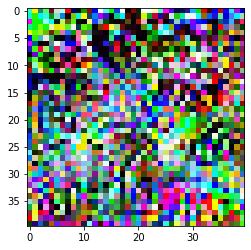

In [156]:
patch_img = Image.fromarray((adv_patch * 255).astype(np.uint8))
patch_img.save("RobustDPatch.jpg")
plt.imshow(patch_img)
plt.show()

In [157]:
pathed_image = attackRobustDPatch.apply_patch(np.float32(images_array))

In [158]:
print(pathed_image.shape)

(2, 500, 500, 3)


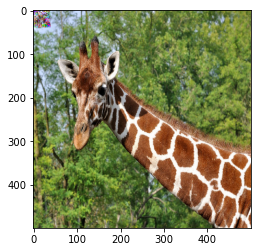

In [159]:
image = Image.fromarray((pathed_image[0,:,:,:]).astype(np.uint8))
plt.imshow(image)
plt.show()

In [160]:
image.save("robust_elephants.jpg")

Attact do something but because we only use one image to generate patch it could work pourly.

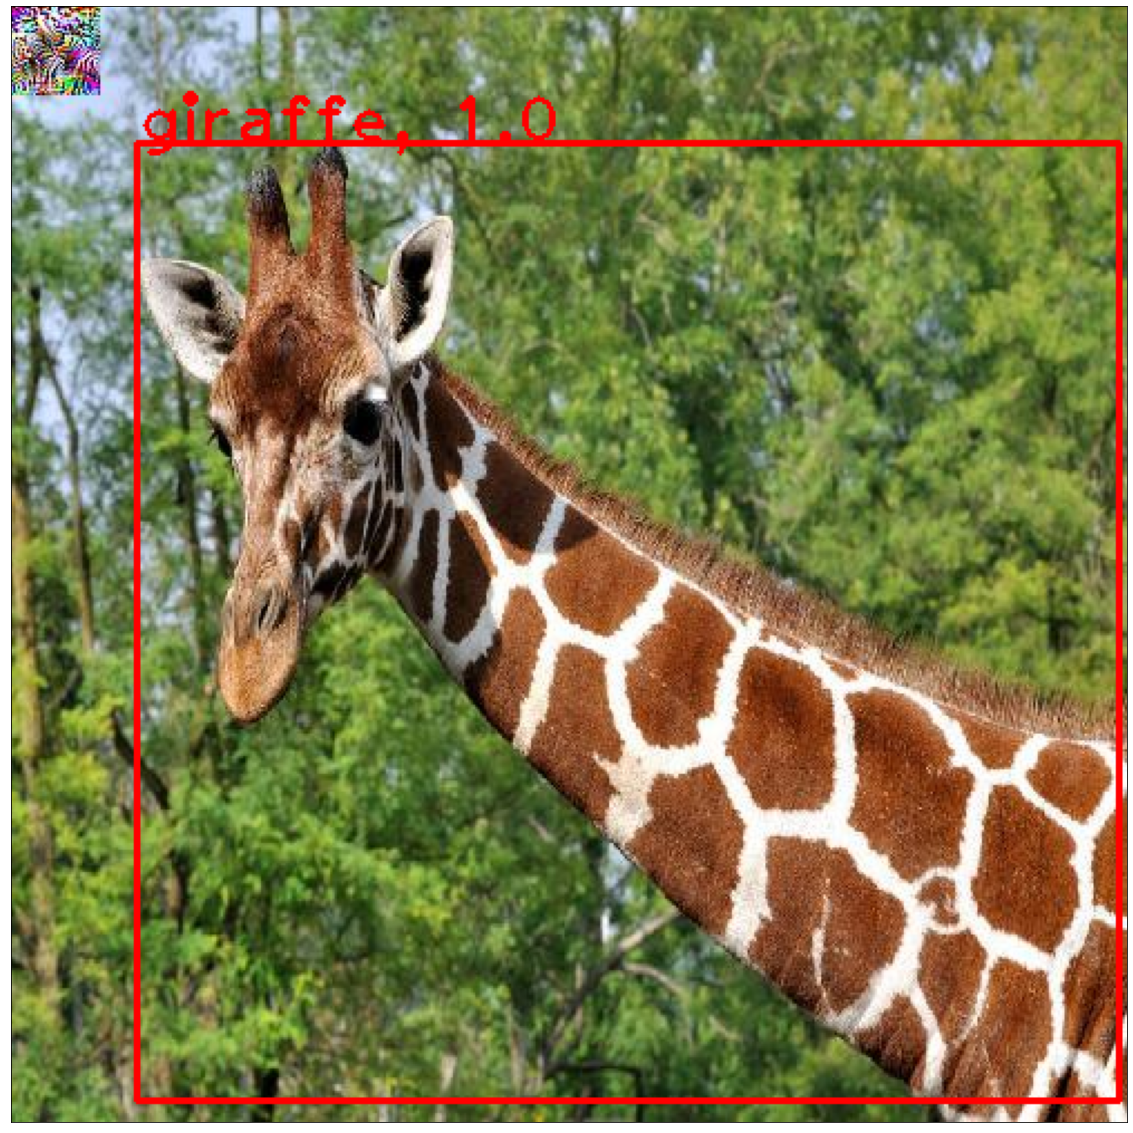

In [161]:
make_images_array("robust_elephants.jpg")

In [155]:
make_predictions("robust_elephants.jpg", art_model)

[{'boxes': array([[ 56.140175,  61.32145 , 496.3968  , 490.78586 ]], dtype=float32),
  'labels': array([25], dtype=int64),
  'scores': array([0.9989266], dtype=float32)}]

In [105]:
print(COCO_INSTANCE_CATEGORY_NAMES[38])

kite
